# Load packages


In [1]:
import os
from pathlib import Path
from zipfile import ZipFile

import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import torch
import torch.nn as nn
import torchtext
import transformers
import umap
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator
from tqdm import tqdm

from scripts.data_loading_utils import load_embedding, read_tweet_data
from scripts.model_training_utils import (
    get_labels_and_predictions,
    plot_confusion_matrix,
    plot_metrics,
    training_loop,
)
from scripts.models import LSTM, BERTClassifier, LSTMWithAttention, count_parameters
from scripts.plotting_utilities import (
    generate_ngram_frequencies,
    generate_wordcloud_with_ngrams,
    plot_top_common_ngrams,
)
from scripts.text_preprocessing_utils import preprocess_tweet
from scripts.tweet_data_set import BERTTweetsDataset, TweetsDataset

print(f"PyTorch version: {torch.__version__}")
print(f"torchtext version: {torchtext.__version__}")

C:\Users\Reslan Al Tinawi\Desktop\CS918-natural-language-processing\cs918-natural-language-processing-assignment\Lib\site-packages\torchtext\vocab\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
C:\Users\Reslan Al Tinawi\Desktop\CS918-natural-language-processing\cs918-natural-language-processing-assignment\Lib\site-packages\torchtext\utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TO

PyTorch version: 2.3.1+cu121
torchtext version: 0.18.0+cpu


In [2]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to C:\Users\Reslan Al
[nltk_data]     Tinawi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
pd.set_option("display.max_colwidth", None)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
print(f"Using device: {device}")

Using device: cuda


# Setup seeds


Seed random generator to guarantee reproducibility:


In [6]:
def seed_everything(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(42)

# Setup Data Path


In [7]:
data_dir_path = Path(os.path.join(os.getcwd(), "data"))

In [8]:
models_weights_dir_path = Path(os.path.join(os.getcwd(), "models_weights"))

In [9]:
print(f"Data directory: {data_dir_path}")
print(f"Models weights directory: {models_weights_dir_path}")

Data directory: C:\Users\Reslan Al Tinawi\Desktop\CS918-natural-language-processing\data
Models weights directory: C:\Users\Reslan Al Tinawi\Desktop\CS918-natural-language-processing\models_weights


# Download GloVe embedding:


In [10]:
# define the URL and the target directory and file
glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
glove_zip_path = os.path.join(data_dir_path, "glove.6B.zip")
glove_file_path = os.path.join(data_dir_path, "glove.6B.100d.txt")

In [11]:
print(glove_zip_path)
print(glove_file_path)

C:\Users\Reslan Al Tinawi\Desktop\CS918-natural-language-processing\data\glove.6B.zip
C:\Users\Reslan Al Tinawi\Desktop\CS918-natural-language-processing\data\glove.6B.100d.txt


In [12]:
# check if the GloVe embeddings already exist
if not os.path.isfile(glove_file_path):
    # download the GloVe embeddings
    print("Downloading GloVe embeddings...")
    response = requests.get(glove_url, stream=True)
    with open(glove_zip_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=128):
            f.write(chunk)

    # extract the specific GloVe file
    print("Extracting GloVe embeddings...")
    with ZipFile(glove_zip_path, "r") as zip_ref:
        zip_ref.extract("glove.6B.100d.txt", path=data_dir_path)

    # clean up by removing the zip file
    os.remove(glove_zip_path)

    print("GloVe embeddings downloaded and extracted to the 'data' folder.")
else:
    print("GloVe embeddings already exist in the 'data' folder.")

GloVe embeddings already exist in the 'data' folder.


# Read data


In [13]:
training_data = read_tweet_data(data_dir_path / "twitter-training-data.txt")

In [14]:
development_data = read_tweet_data(data_dir_path / "twitter-dev-data.txt")

In [15]:
test1_data = read_tweet_data(data_dir_path / "twitter-test1.txt")

In [16]:
test2_data = read_tweet_data(data_dir_path / "twitter-test2.txt")

In [17]:
test3_data = read_tweet_data(data_dir_path / "twitter-test3.txt")

In [18]:
training_data.head()

tweet_id tweet_sentiment  \
0  335104872099066692        positive   
1  796528524030124618        positive   
2  760964834217238632        positive   
3  147713180324524046        negative   
4  732302280474120023        negative   

                                                                                                                                       tweet_text  
0                                  Felt privileged to play Foo Fighters songs on guitar today with one of the plectrums from the gig on Saturday.  
1  "@AaqibAfzaal Pakistan may be an Islamic country, but der are a lot true Muslims in India who love their country and can sacrifice all for it"  
2     Happy Birthday to the coolest golfer in Bali! @tjvictoriacnd !! :) may you become cooler and cooler everyday! Stay humble little sister! Xx  
3                                                                     @SimpplyA TMILLS is going to Tucson! But the 29th and it's on a Thursday :(  
4                           Hmmmmm where are the #BlackLivesMatter when matters like this a rise... kids are a disgrace!! https://t.co/aPrB0VtvCN

In [19]:
print(f"Training data: {training_data['tweet_sentiment'].value_counts().to_dict()}")
print(
    f"Development data: {development_data['tweet_sentiment'].value_counts().to_dict()}"
)

Training data: {'neutral': 20789, 'positive': 15986, 'negative': 8326}
Development data: {'neutral': 919, 'positive': 703, 'negative': 378}


In [20]:
print(
    f"Training data: {training_data['tweet_sentiment'].value_counts(normalize=True).to_dict()}"
)

print(
    f"Development data: {development_data['tweet_sentiment'].value_counts(normalize=True).to_dict()}"
)

Training data: {'neutral': 0.4609432163366666, 'positive': 0.3544489035719829, 'negative': 0.1846078800913505}
Development data: {'neutral': 0.4595, 'positive': 0.3515, 'negative': 0.189}


# Data Cleaning & Exploratory Data Analysis


In [21]:
tokenizer = TweetTokenizer()

In [22]:
# this code takes 20 seconds
training_data["tweet_text_cleaned"] = training_data["tweet_text"].apply(
    lambda tweet: preprocess_tweet(tweet, tokenizer)
)

In [23]:
development_data["tweet_text_cleaned"] = development_data["tweet_text"].apply(
    lambda tweet: preprocess_tweet(tweet, tokenizer)
)

In [24]:
test1_data["tweet_text_cleaned"] = test1_data["tweet_text"].apply(
    lambda tweet: preprocess_tweet(tweet, tokenizer)
)

In [25]:
test2_data["tweet_text_cleaned"] = test2_data["tweet_text"].apply(
    lambda tweet: preprocess_tweet(tweet, tokenizer)
)

In [26]:
test3_data["tweet_text_cleaned"] = test3_data["tweet_text"].apply(
    lambda tweet: preprocess_tweet(tweet, tokenizer)
)

In [27]:
positive_tweets = training_data[training_data["tweet_sentiment"] == "positive"]
negative_tweets = training_data[training_data["tweet_sentiment"] == "negative"]
neutral_tweets = training_data[training_data["tweet_sentiment"] == "neutral"]

## Tweet length:


In [28]:
training_data["tweet_length"] = training_data["tweet_text"].str.len()
training_data["tweet_cleaned_length"] = training_data["tweet_text_cleaned"].str.len()

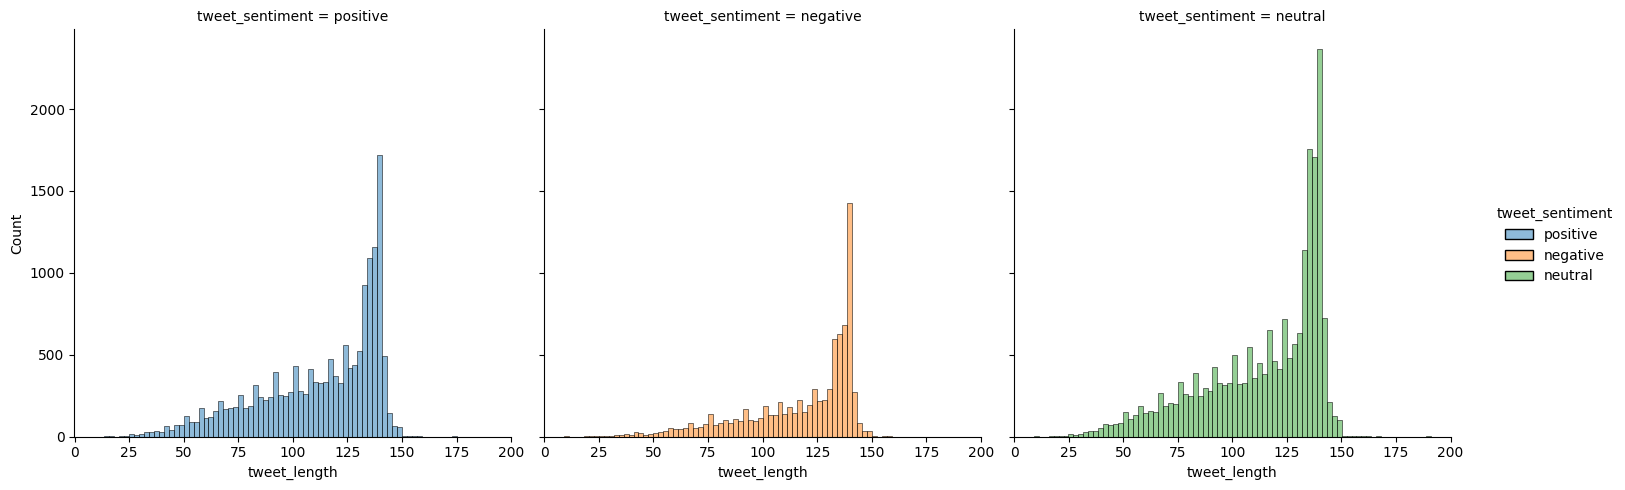

In [29]:
sns.displot(
    data=training_data,
    x="tweet_length",
    hue="tweet_sentiment",
    col="tweet_sentiment",
)

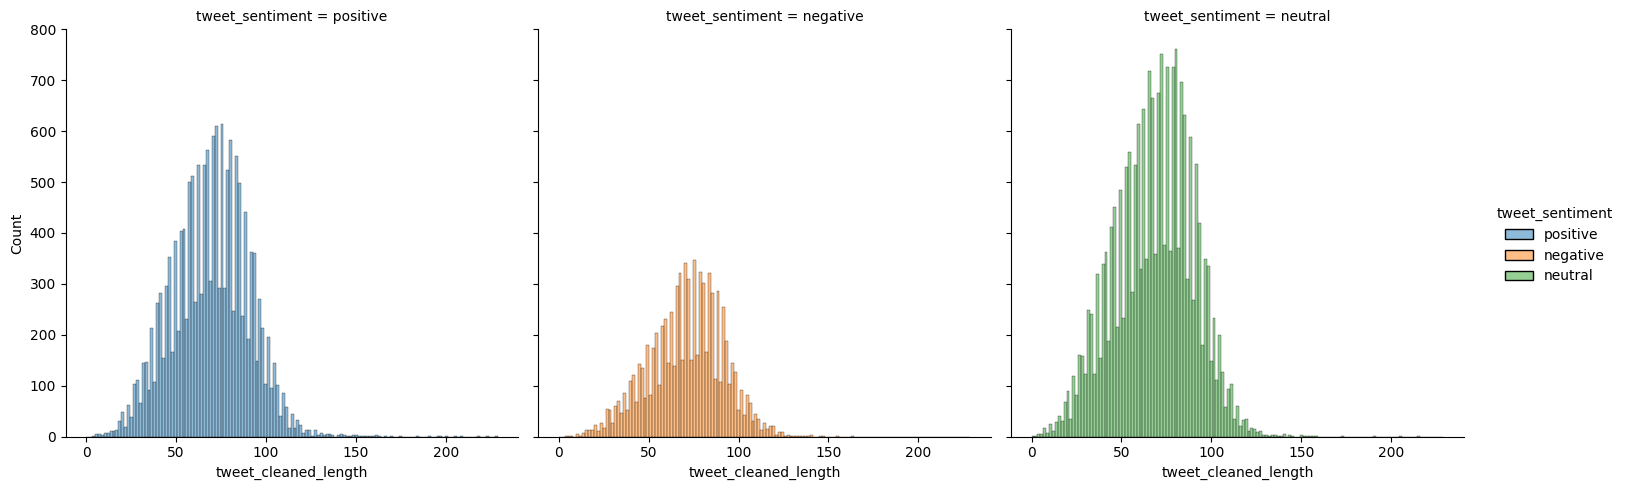

In [30]:
sns.displot(
    data=training_data,
    x="tweet_cleaned_length",
    hue="tweet_sentiment",
    col="tweet_sentiment",
)

## Generate n-grams frequencies


In [31]:
positive_unigram_freq = generate_ngram_frequencies(
    corpus=positive_tweets["tweet_text_cleaned"], n_grams=1, max_features=1000
)

positive_bigram_freq = generate_ngram_frequencies(
    corpus=positive_tweets["tweet_text_cleaned"], n_grams=2, max_features=1000
)

positive_trigram_freq = generate_ngram_frequencies(
    corpus=positive_tweets["tweet_text_cleaned"], n_grams=3, max_features=1000
)

In [32]:
negative_unigram_freq = generate_ngram_frequencies(
    corpus=negative_tweets["tweet_text_cleaned"], n_grams=1, max_features=1000
)

negative_bigram_freq = generate_ngram_frequencies(
    corpus=negative_tweets["tweet_text_cleaned"], n_grams=2, max_features=1000
)

negative_trigram_freq = generate_ngram_frequencies(
    corpus=negative_tweets["tweet_text_cleaned"], n_grams=3, max_features=1000
)

In [33]:
neutral_unigram_freq = generate_ngram_frequencies(
    corpus=neutral_tweets["tweet_text_cleaned"], n_grams=1, max_features=1000
)

neutral_bigram_freq = generate_ngram_frequencies(
    corpus=neutral_tweets["tweet_text_cleaned"], n_grams=2, max_features=1000
)

neutral_trigram_freq = generate_ngram_frequencies(
    corpus=neutral_tweets["tweet_text_cleaned"], n_grams=3, max_features=1000
)

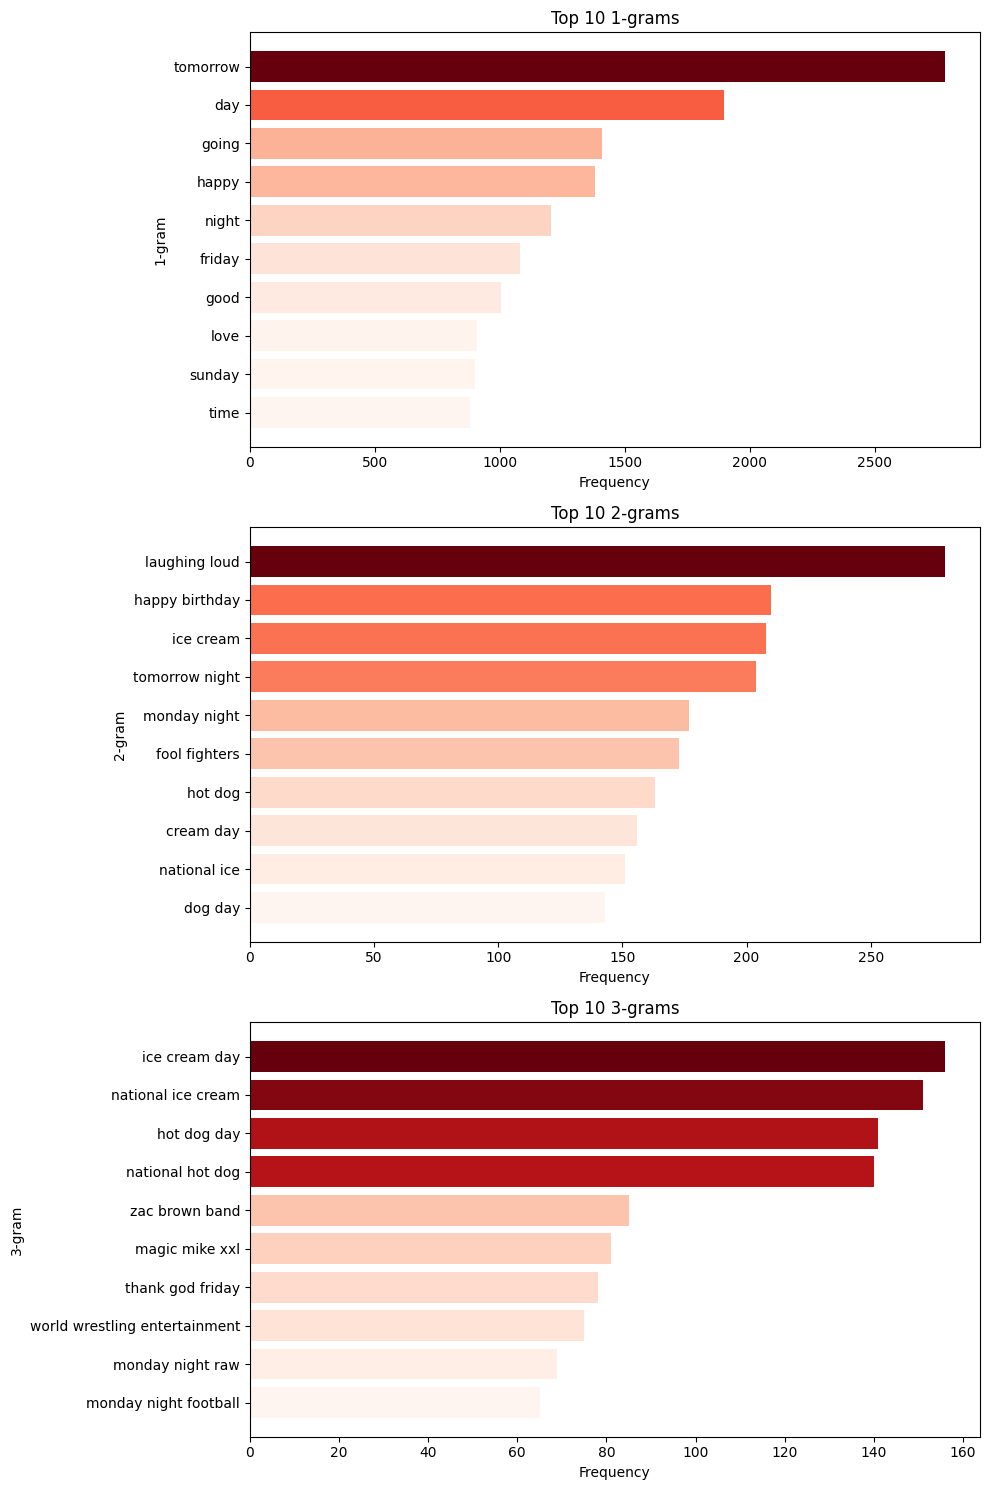

In [34]:
plot_top_common_ngrams(
    [positive_unigram_freq, positive_bigram_freq, positive_trigram_freq]
)

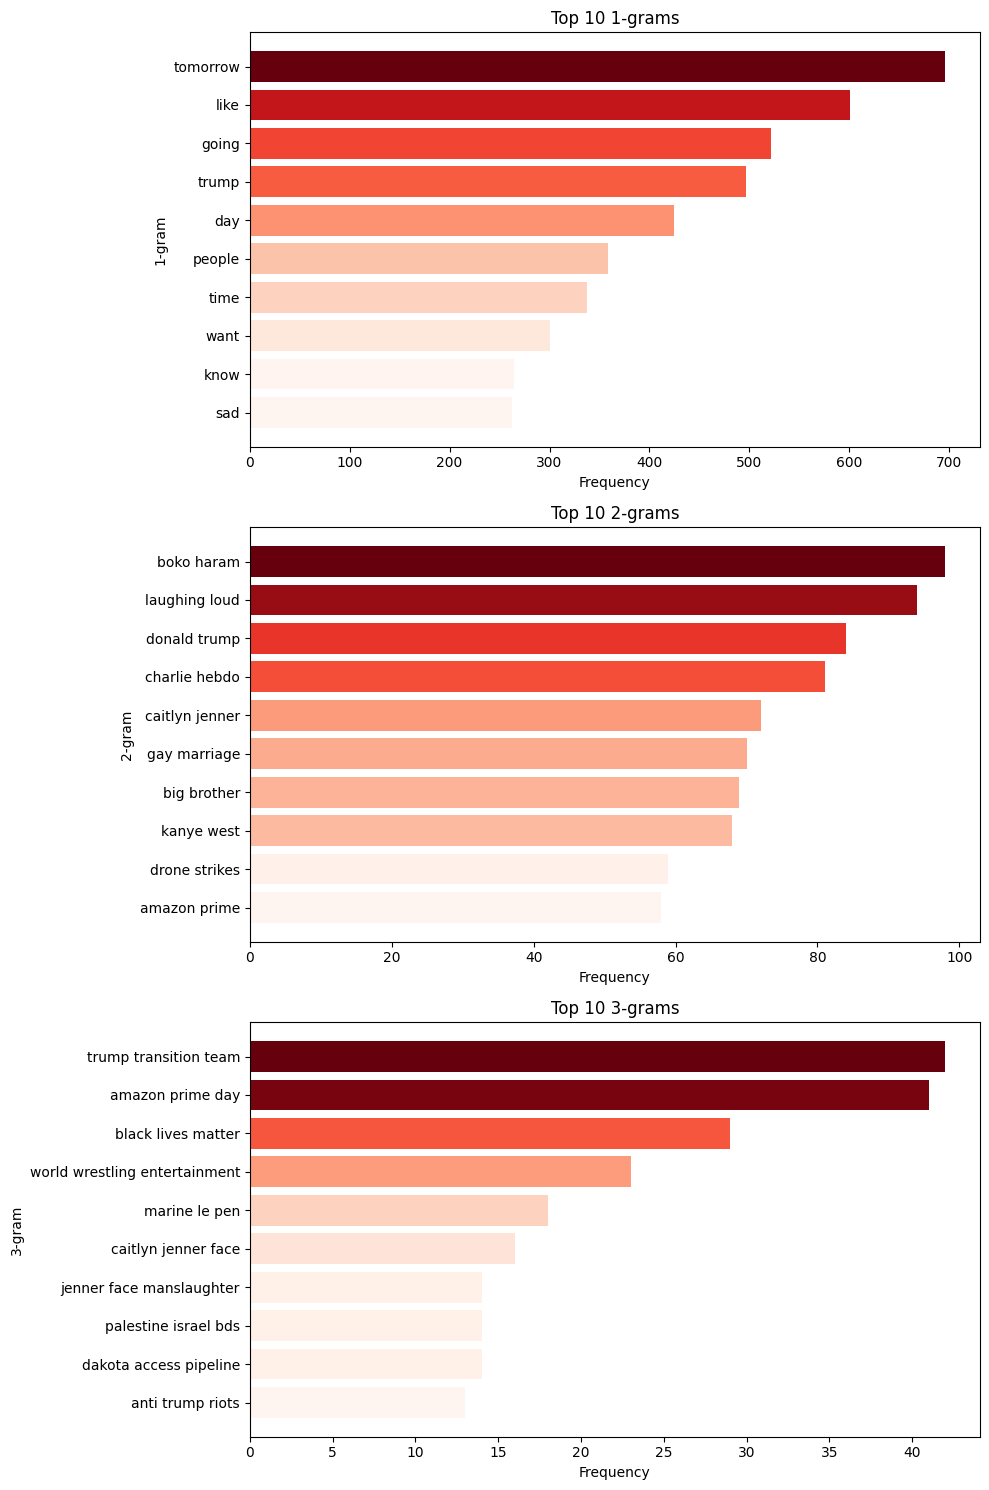

In [35]:
plot_top_common_ngrams(
    [negative_unigram_freq, negative_bigram_freq, negative_trigram_freq]
)

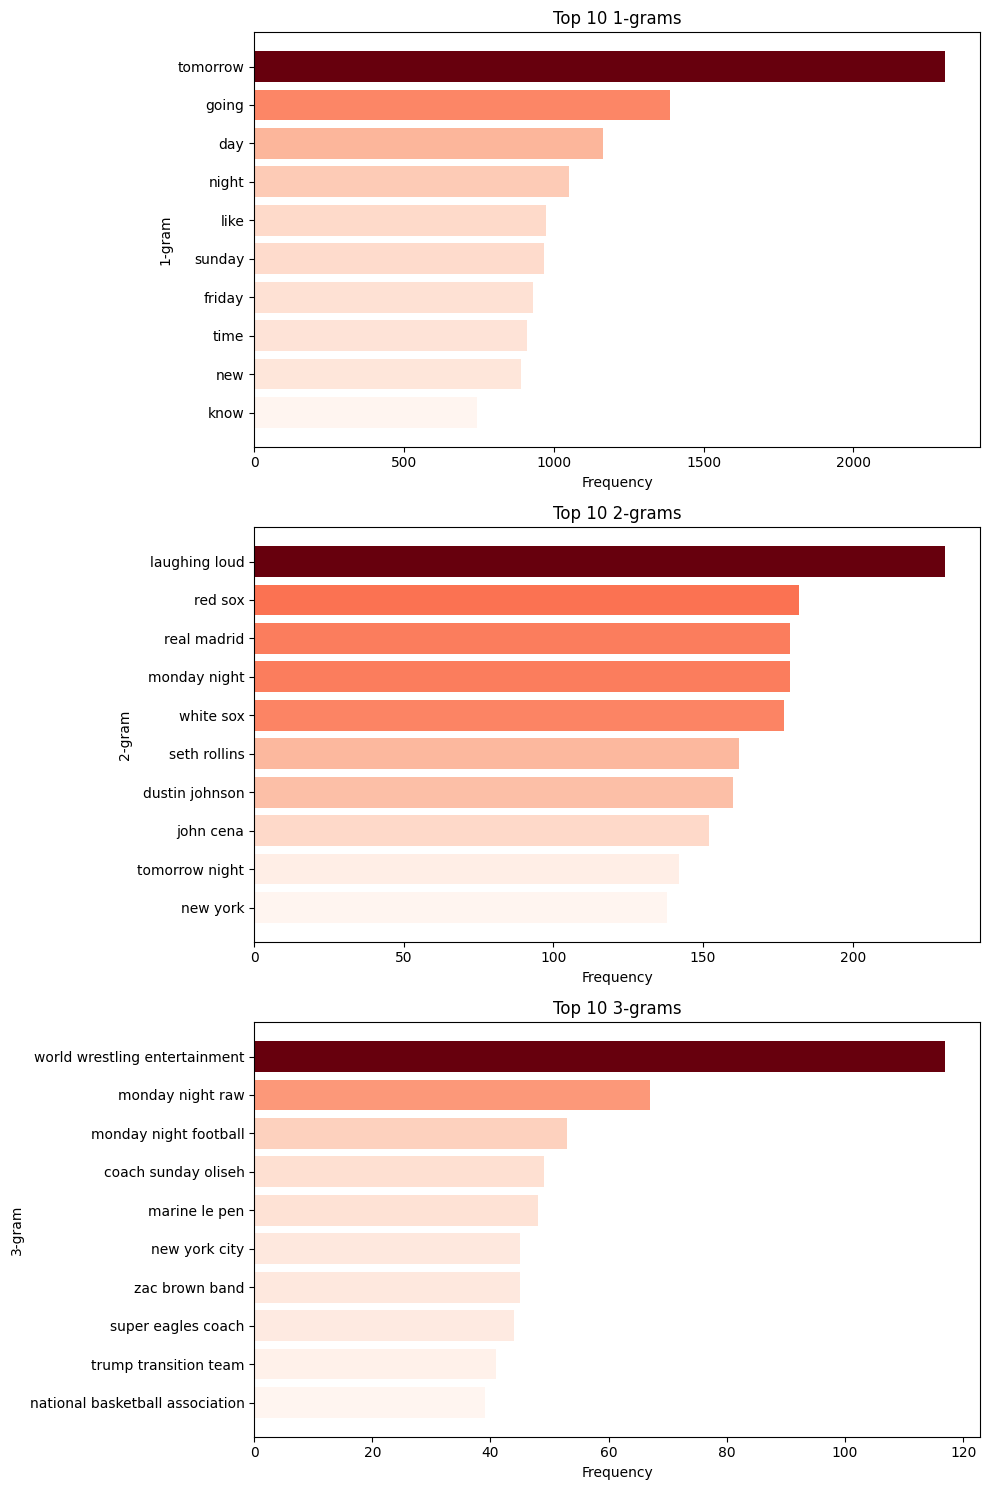

In [36]:
plot_top_common_ngrams(
    [neutral_unigram_freq, neutral_bigram_freq, neutral_trigram_freq]
)

## Generate wordclouds


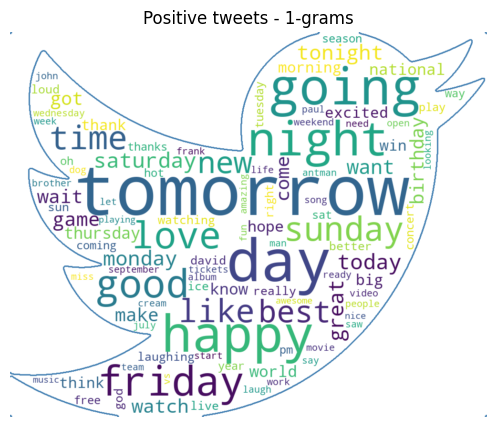

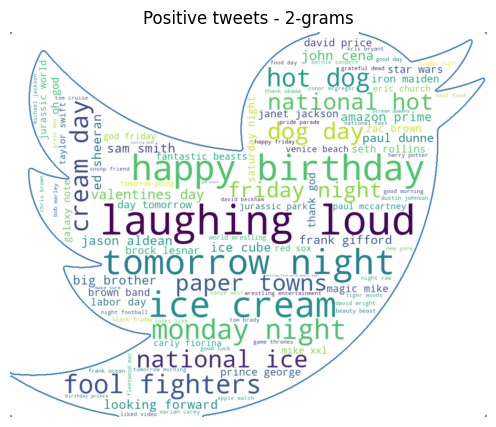

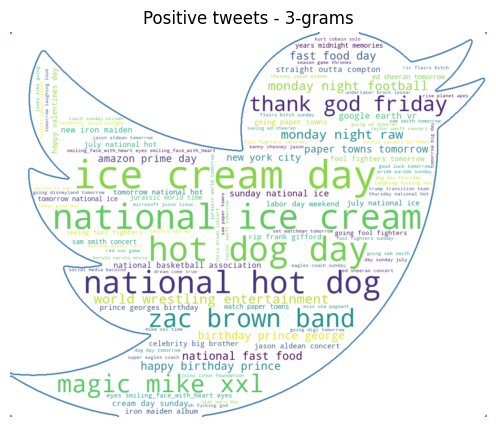

In [37]:
for idx, n_gram_freq_dict in enumerate(
    [positive_unigram_freq, positive_bigram_freq, positive_trigram_freq]
):
    generate_wordcloud_with_ngrams(n_gram_freq_dict, idx + 1, "Positive tweets")

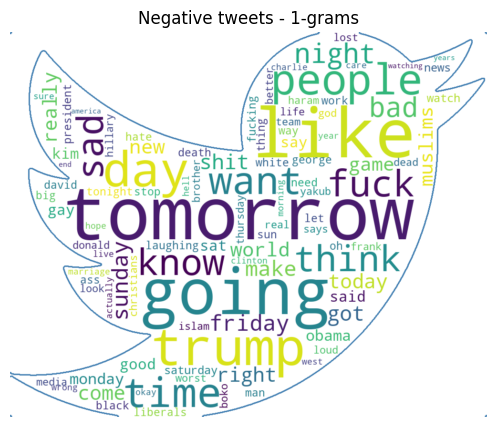

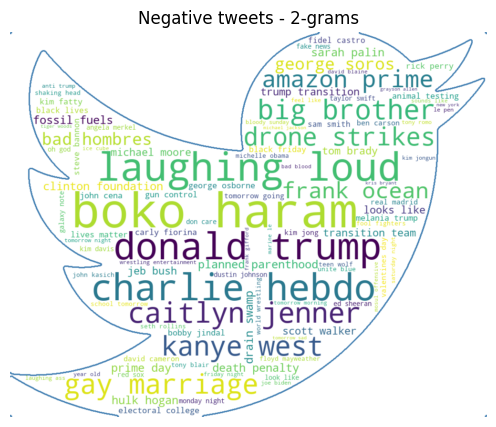

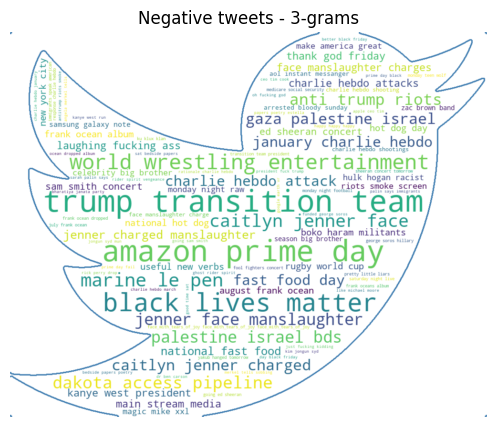

In [38]:
for idx, n_gram_freq_dict in enumerate(
    [negative_unigram_freq, negative_bigram_freq, negative_trigram_freq]
):
    generate_wordcloud_with_ngrams(n_gram_freq_dict, idx + 1, "Negative tweets")

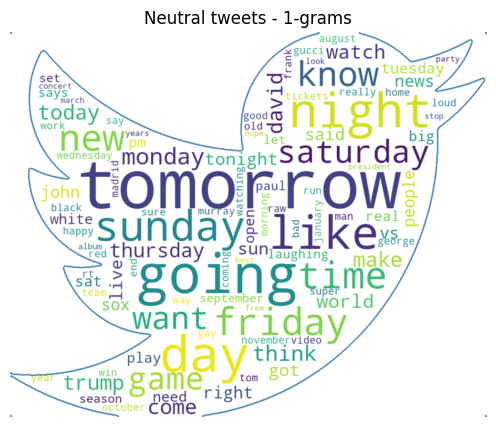

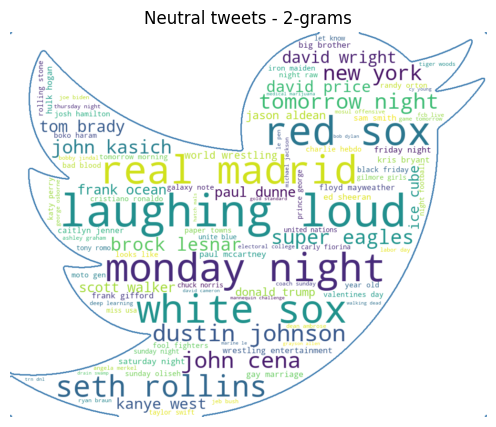

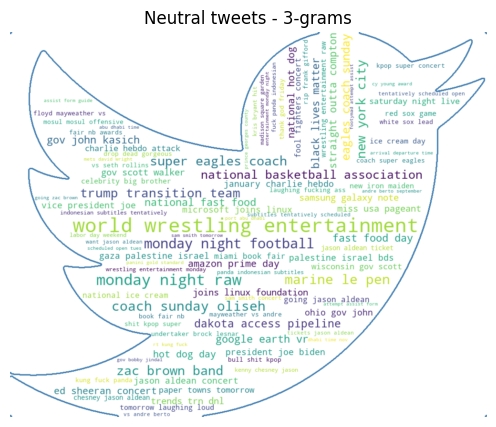

In [39]:
for idx, n_gram_freq_dict in enumerate(
    [neutral_unigram_freq, neutral_bigram_freq, neutral_trigram_freq]
):
    generate_wordcloud_with_ngrams(n_gram_freq_dict, idx + 1, "Neutral tweets")

## UMAP


Generate a scatter plot of the data by reducing its dimensionality using TF-IDF features and UMAP algorithm:


In [40]:
tfidf_vectorizer = TfidfVectorizer(
    min_df=5, stop_words="english", ngram_range=(1, 3), max_features=5000
)

In [41]:
tfidf_word_doc_matrix = tfidf_vectorizer.fit_transform(
    training_data["tweet_text_cleaned"]
)

In [42]:
# this code takes 50 seconds
tfidf_embedding = umap.UMAP(metric="hellinger").fit(tfidf_word_doc_matrix)

C:\Users\Reslan Al Tinawi\Desktop\CS918-natural-language-processing\cs918-natural-language-processing-assignment\Lib\site-packages\umap\umap_.py:127: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 3358 edges.
It has only fully disconnected 110 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


<Axes: >

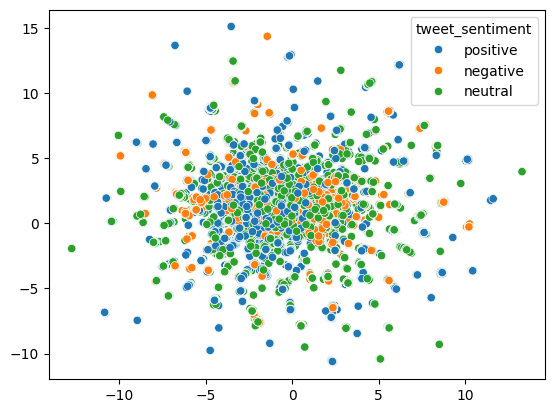

In [43]:
sns.scatterplot(
    x=tfidf_embedding.embedding_[:, 0],
    y=tfidf_embedding.embedding_[:, 1],
    hue=training_data["tweet_sentiment"],
)

# Classification using traditional machine learning models


## Split data


Split training data into training and validation for performing K-fold cross validation.


In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    training_data["tweet_text_cleaned"],
    training_data["tweet_sentiment"],
    test_size=0.2,
    random_state=42,
    stratify=training_data["tweet_sentiment"],
)

In [45]:
print(f"Training data: {y_train.value_counts(normalize=True).to_dict()}")
print(f"Test data: {y_test.value_counts(normalize=True).to_dict()}")

Training data: {'neutral': 0.4609478935698448, 'positive': 0.35443458980044346, 'negative': 0.18461751662971176}
Test data: {'neutral': 0.46092450947788494, 'positive': 0.3545061523112737, 'negative': 0.18456933821084137}


## Naive Bayes


In [46]:
naive_bayes_pipeline = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("clf", MultinomialNB()),
    ]
)

In [47]:
parameters = {
    "vect": [TfidfVectorizer(), CountVectorizer()],
    "vect__stop_words": ["english"],
    "vect__max_df": (0.5, 0.75, 1.0),
    "vect__min_df": [5, 10, 15],
    "vect__max_features": (None, 5000, 10000, 50000),
    "vect__ngram_range": [(1, 1), (1, 2), (1, 3)],
    "clf__alpha": (0.01, 0.1, 1),
}

In [48]:
naive_bayes_grid_search = GridSearchCV(
    naive_bayes_pipeline, parameters, cv=5, n_jobs=-1, verbose=1
)

In [49]:
# this code takes 10 minutes and 45 seconds
naive_bayes_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf__alpha': (0.01, 0.1, 1),
                         'vect': [TfidfVectorizer(), CountVectorizer()],
                         'vect__max_df': (0.5, 0.75, 1.0),
                         'vect__max_features': (None, 5000, 10000, 50000),
                         'vect__min_df': [5, 10, 15],
                         'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'vect__stop_words': ['english']},
             verbose=1)

In [50]:
print("Best score: %0.3f" % naive_bayes_grid_search.best_score_)
print("Best parameters set:")
best_parameters = naive_bayes_grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.615
Best parameters set:
	clf__alpha: 1
	vect: TfidfVectorizer(max_df=0.5, max_features=5000, min_df=5, stop_words='english')
	vect__max_df: 0.5
	vect__max_features: 5000
	vect__min_df: 5
	vect__ngram_range: (1, 1)
	vect__stop_words: 'english'


In [51]:
y_pred = naive_bayes_grid_search.best_estimator_.predict(X_test)

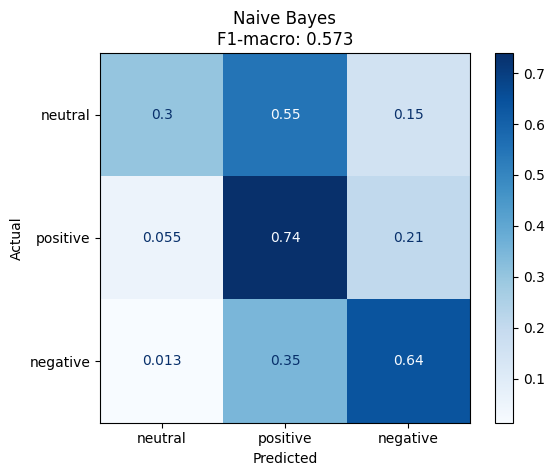

In [52]:
plot_confusion_matrix(y_test, y_pred, "Naive Bayes")

In [53]:
naive_bayes_model_path = models_weights_dir_path / "naive_bayes_model.joblib"
joblib.dump(naive_bayes_grid_search.best_estimator_, naive_bayes_model_path)

['C:\\Users\\Reslan Al Tinawi\\Desktop\\CS918-natural-language-processing\\models_weights\\naive_bayes_model.joblib']

## Logistic Regression


In [54]:
logistic_regression_pipeline = Pipeline(
    [
        ("vect", CountVectorizer()),
        (
            "clf",
            LogisticRegression(max_iter=500, random_state=42),
        ),
    ]
)

In [55]:
parameters = {
    "vect": [TfidfVectorizer(), CountVectorizer()],
    "vect__stop_words": ["english"],
    "vect__min_df": [10, 15, 25],
    "vect__max_features": (500, 1000),
    "vect__ngram_range": [(1, 1), (1, 2), (1, 3)],
    "clf__C": [0.001, 0.01, 0.1, 1, 10, 100],
}

In [56]:
logistic_regression_grid_search = GridSearchCV(
    logistic_regression_pipeline, parameters, cv=5, n_jobs=-1, verbose=1
)

In [57]:
# this code takes 3 minutes
logistic_regression_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('clf',
                                        LogisticRegression(max_iter=500,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'vect': [TfidfVectorizer(), CountVectorizer()],
                         'vect__max_features': (500, 1000),
                         'vect__min_df': [10, 15, 25],
                         'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'vect__stop_words': ['english']},
             verbose=1)

In [58]:
print("Best score: %0.3f" % logistic_regression_grid_search.best_score_)
print("Best parameters set:")
best_parameters = logistic_regression_grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.628
Best parameters set:
	clf__C: 1
	vect: TfidfVectorizer(max_features=1000, min_df=10, stop_words='english')
	vect__max_features: 1000
	vect__min_df: 10
	vect__ngram_range: (1, 1)
	vect__stop_words: 'english'


In [59]:
# Evaluate the best grid search pipeline on the test dataset
y_pred = logistic_regression_grid_search.predict(X_test)

In [60]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.57      0.32      0.41      1665
     neutral       0.60      0.77      0.68      4158
    positive       0.69      0.61      0.65      3198

    accuracy                           0.63      9021
   macro avg       0.62      0.56      0.58      9021
weighted avg       0.63      0.63      0.62      9021



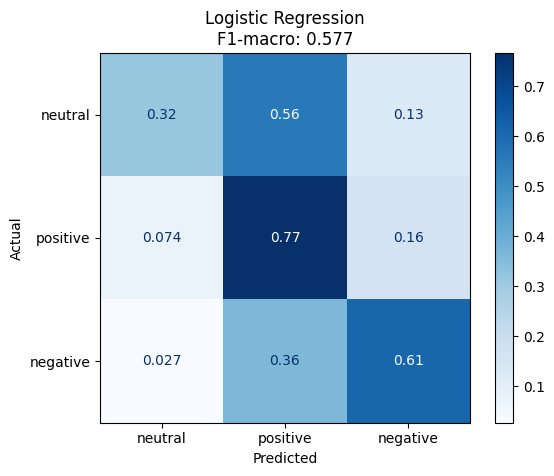

In [61]:
plot_confusion_matrix(y_test, y_pred, "Logistic Regression")

In [62]:
joblib.dump(
    logistic_regression_grid_search.best_estimator_,
    models_weights_dir_path / "logistic_regression_model.joblib",
)

['C:\\Users\\Reslan Al Tinawi\\Desktop\\CS918-natural-language-processing\\models_weights\\logistic_regression_model.joblib']

## SVC


In [63]:
svm_pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer(max_features=1000, min_df=10, stop_words="english")),
        ("clf", SVC(random_state=42)),
    ]
)

In [64]:
# this code takes 2 minutes and 20 seconds
svm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_features=1000, min_df=10,
                                 stop_words='english')),
                ('clf', SVC(random_state=42))])

In [65]:
y_pred = svm_pipeline.predict(X_test)

In [66]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.59      0.28      0.38      1665
     neutral       0.59      0.81      0.68      4158
    positive       0.72      0.58      0.64      3198

    accuracy                           0.63      9021
   macro avg       0.64      0.56      0.57      9021
weighted avg       0.64      0.63      0.61      9021



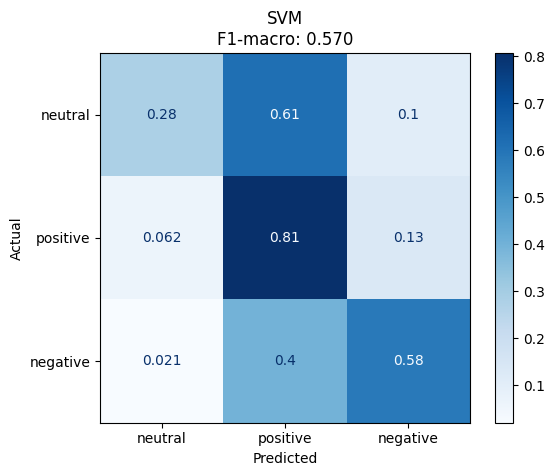

In [67]:
plot_confusion_matrix(y_test, y_pred, "SVM")

In [68]:
joblib.dump(svm_pipeline, models_weights_dir_path / "svm_model.joblib")

['C:\\Users\\Reslan Al Tinawi\\Desktop\\CS918-natural-language-processing\\models_weights\\svm_model.joblib']

# Deep Learning Models


## Load GloVe embedding:


In [69]:
embedding_file_name = "glove.6B.100d.txt"
glove_embedding_dict = load_embedding(data_dir_path / embedding_file_name)

In [70]:
print(f"Number of words in GloVe embedding: {len(glove_embedding_dict):,}")

Number of words in GloVe embedding: 400,000


In [71]:
def yield_tokens(tweets_list):
    for tweet in tweets_list:
        yield tweet.strip().split()

In [72]:
# set max tokens to 5000
special_tokens = ["<unk>", "<pad>"]
min_freq = 5
max_tokens = 5000

In [73]:
vocab = build_vocab_from_iterator(
    iterator=yield_tokens(training_data["tweet_text_cleaned"].tolist()),
    min_freq=min_freq,
    specials=special_tokens,
    max_tokens=max_tokens,
)

In [74]:
unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]
vocab.set_default_index(vocab["<unk>"])

In [75]:
print(f"Vocabulary size: {len(vocab)}")

Vocabulary size: 5000


## Build embedding matrix


In [76]:
vocab_size = len(vocab)
embedding_dim = 100
embedding_matrix = torch.zeros((vocab_size, embedding_dim))

In [77]:
print(embedding_matrix.shape)

torch.Size([5000, 100])


Initialize the `embedding_matrix` with `GloVe` vectors.

If a given word from the vocab don't have a corresponding `GloVe` embedding, initialized it with a _random_ embedding.


In [78]:
unknown_words = []

In [79]:
for word, idx in tqdm(vocab.get_stoi().items()):
    if word in glove_embedding_dict:
        embedding_matrix[idx] = torch.tensor(glove_embedding_dict[word])
    else:
        unknown_words.append(word)
        embedding_matrix[idx] = torch.randn(embedding_dim)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 45519.71it/s]


In [80]:
embedding_matrix.shape

torch.Size([5000, 100])

In [81]:
print(
    f"There are {len(unknown_words)} ({len(unknown_words) / len(vocab):.2f}%) words in the vocabulary that are not in the GloVe embedding."
)

There are 83 (0.02%) words in the vocabulary that are not in the GloVe embedding.


In [82]:
print(unknown_words)

['<red_heart>', '<unk>', '<pad>', '<happy>', "don't", 'assface', '<sad>', '<united_states>', 'altrightists', 'xfactor', '<crying_face>', '<laugh>', 'sharknado', 'retweet', "it's", 'tmobile', "can't", 'djt', 'netwok', '<tong>', 'calibraska', 'madrids', '<wink>', 'hahahaha', '<face_with_tears_of_joy>', '<blue_heart>', 'altright', 'mayweathers', 'erdogans', 'yearold', 'jayz', 'beyonces', '<annoyed>', 'nialls', 'deplorables', 'brexit', 'witho', 'appleevent', 'yakubs', 'tonights', 'zayns', '<loudly_crying_face>', '<smiling_face_with_heart-eyes>', 'hahaha', 'jongun', 'directioners', 'antitrump', 'mufc', '<thinking_face>', 'nickis', 'arsed', 'shawns', 'retweeted', 'rouseys', "fuck's", '<beaming_face_with_smiling_eyes>', 'sonys', 'nigerias', 'nufc', 'boruto', 'tshirt', '<fire>', 'gunna', 'melanias', '<enraged_face>', '<smiling_face_with_smiling_eyes>', 'mmm....ok', 'cenas', 'egypts', 'vernau', 'lolla', 'justins', 'selfie', '<face_with_rolling_eyes>', 'samsungs', 'nirvanas', 'messanger', "that'

## Define Datasets and Dataloaders


In [83]:
encoder = LabelEncoder()

encoder.fit(training_data["tweet_sentiment"])

LabelEncoder()

In [84]:
print(encoder.classes_)

['negative' 'neutral' 'positive']


In [85]:
train_dataset = TweetsDataset(
    tweet_ids=training_data["tweet_id"],
    tweets=training_data["tweet_text_cleaned"],
    labels=training_data["tweet_sentiment"],
    vocab=vocab,
    label_encoder=encoder,
)

In [86]:
development_dataset = TweetsDataset(
    tweet_ids=development_data["tweet_id"],
    tweets=development_data["tweet_text_cleaned"],
    labels=development_data["tweet_sentiment"],
    vocab=vocab,
    label_encoder=encoder,
)

In [87]:
test1_dataset = TweetsDataset(
    tweet_ids=test1_data["tweet_id"],
    tweets=test1_data["tweet_text_cleaned"],
    labels=test1_data["tweet_sentiment"],
    vocab=vocab,
    label_encoder=encoder,
)

In [88]:
test2_dataset = TweetsDataset(
    tweet_ids=test2_data["tweet_id"],
    tweets=test2_data["tweet_text_cleaned"],
    labels=test2_data["tweet_sentiment"],
    vocab=vocab,
    label_encoder=encoder,
)

In [89]:
test3_dataset = TweetsDataset(
    tweet_ids=test3_data["tweet_id"],
    tweets=test3_data["tweet_text_cleaned"],
    labels=test3_data["tweet_sentiment"],
    vocab=vocab,
    label_encoder=encoder,
)

In [90]:
def collate_batch(batch):
    tweet_ids = np.array([item[0] for item in batch])
    tweets = [item[1] for item in batch]
    labels = np.array([item[2] for item in batch])

    padded_tweets = pad_sequence(tweets, batch_first=True, padding_value=vocab["<pad>"])

    return tweet_ids, padded_tweets, torch.from_numpy(labels).to(dtype=torch.long)

In [91]:
batch_size = 256

In [92]:
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch
)

development_dataloader = DataLoader(
    development_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch
)

test1_dataloader = DataLoader(
    test1_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch
)

test2_dataloader = DataLoader(
    test2_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch
)

test3_dataloader = DataLoader(
    test3_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch
)

## LSTM


In [93]:
vocab_size = len(vocab)
embedding_dim = 100
hidden_dim = 300
output_dim = 3
n_layers = 2
bidirectional = True
dropout_rate = 0.5

In [94]:
lstm_model = LSTM(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    bidirectional,
    dropout_rate,
    pad_index,
)

In [95]:
print(f"The LSTM model has {count_parameters(lstm_model):,} trainable parameters")

The LSTM model has 3,131,403 trainable parameters


In [96]:
lstm_model.embedding.weight.data = embedding_matrix

In [97]:
n_epochs = 20
lr = 5e-4
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lr)

In [98]:
criterion = nn.CrossEntropyLoss()

In [99]:
lstm_model = lstm_model.to(device)
criterion = criterion.to(device)

In [100]:
lstm_model_path = models_weights_dir_path / "lstm_model.pt"

In [101]:
# this code takes one minute
metrics = training_loop(
    n_epochs,
    train_dataloader,
    development_dataloader,
    lstm_model,
    criterion,
    optimizer,
    device,
    False,
    None,
    lstm_model_path,
)

Evaluating Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 51.04it/s]


Saving model with valid loss: 0.874
epoch: 1
train_loss: 0.947, train_acc: 0.531
valid_loss: 0.874, valid_acc: 0.582


Evaluating Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 56.72it/s]


Saving model with valid loss: 0.853
epoch: 2
train_loss: 0.900, train_acc: 0.565
valid_loss: 0.853, valid_acc: 0.590


Evaluating Epoch 3: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 56.51it/s]


Saving model with valid loss: 0.836
epoch: 3
train_loss: 0.882, train_acc: 0.573
valid_loss: 0.836, valid_acc: 0.601


Evaluating Epoch 4: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 56.72it/s]


Saving model with valid loss: 0.818
epoch: 4
train_loss: 0.870, train_acc: 0.584
valid_loss: 0.818, valid_acc: 0.624


Evaluating Epoch 5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 50.92it/s]


Saving model with valid loss: 0.816
epoch: 5
train_loss: 0.859, train_acc: 0.593
valid_loss: 0.816, valid_acc: 0.623


Evaluating Epoch 6: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 50.93it/s]


Saving model with valid loss: 0.799
epoch: 6
train_loss: 0.850, train_acc: 0.600
valid_loss: 0.799, valid_acc: 0.636


Evaluating Epoch 7: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 56.72it/s]


epoch: 7
train_loss: 0.844, train_acc: 0.603
valid_loss: 0.811, valid_acc: 0.616


Evaluating Epoch 8: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 46.29it/s]


Saving model with valid loss: 0.798
epoch: 8
train_loss: 0.834, train_acc: 0.609
valid_loss: 0.798, valid_acc: 0.633


Evaluating Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 49.02it/s]


Saving model with valid loss: 0.782
epoch: 9
train_loss: 0.828, train_acc: 0.613
valid_loss: 0.782, valid_acc: 0.641


Evaluating Epoch 10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 46.32it/s]


Saving model with valid loss: 0.779
epoch: 10
train_loss: 0.819, train_acc: 0.617
valid_loss: 0.779, valid_acc: 0.638


Evaluating Epoch 11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 46.43it/s]


epoch: 11
train_loss: 0.813, train_acc: 0.625
valid_loss: 0.781, valid_acc: 0.649


Evaluating Epoch 12: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 46.32it/s]


Saving model with valid loss: 0.772
epoch: 12
train_loss: 0.810, train_acc: 0.628
valid_loss: 0.772, valid_acc: 0.649


Evaluating Epoch 13: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 50.93it/s]


Saving model with valid loss: 0.770
epoch: 13
train_loss: 0.806, train_acc: 0.626
valid_loss: 0.770, valid_acc: 0.649


Evaluating Epoch 14: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 51.07it/s]


epoch: 14
train_loss: 0.799, train_acc: 0.632
valid_loss: 0.772, valid_acc: 0.654


Evaluating Epoch 15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 50.92it/s]


epoch: 15
train_loss: 0.796, train_acc: 0.631
valid_loss: 0.775, valid_acc: 0.651


Evaluating Epoch 16: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 42.57it/s]


Saving model with valid loss: 0.766
epoch: 16
train_loss: 0.791, train_acc: 0.635
valid_loss: 0.766, valid_acc: 0.651


Evaluating Epoch 17: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 50.93it/s]


Saving model with valid loss: 0.755
epoch: 17
train_loss: 0.788, train_acc: 0.637
valid_loss: 0.755, valid_acc: 0.655


Evaluating Epoch 18: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 50.91it/s]


epoch: 18
train_loss: 0.783, train_acc: 0.642
valid_loss: 0.765, valid_acc: 0.650


Evaluating Epoch 19: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 51.07it/s]


epoch: 19
train_loss: 0.778, train_acc: 0.642
valid_loss: 0.781, valid_acc: 0.632


Evaluating Epoch 20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 50.91it/s]

epoch: 20
train_loss: 0.773, train_acc: 0.645
valid_loss: 0.771, valid_acc: 0.648


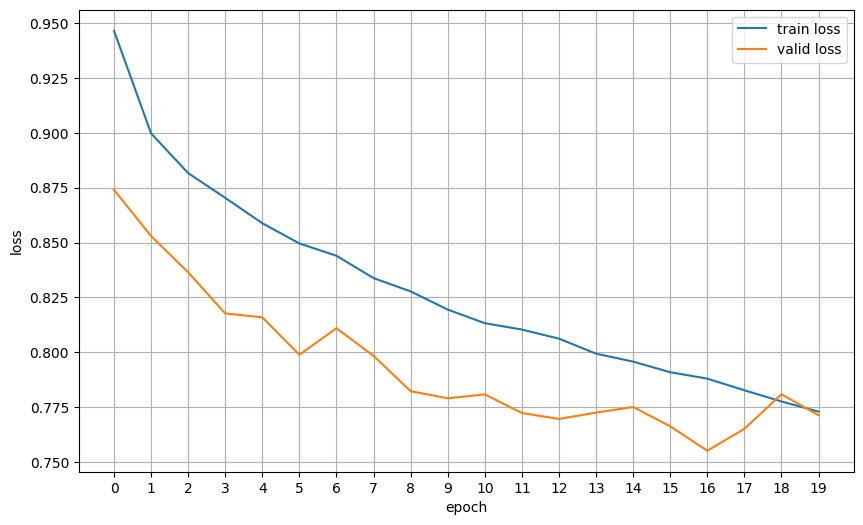

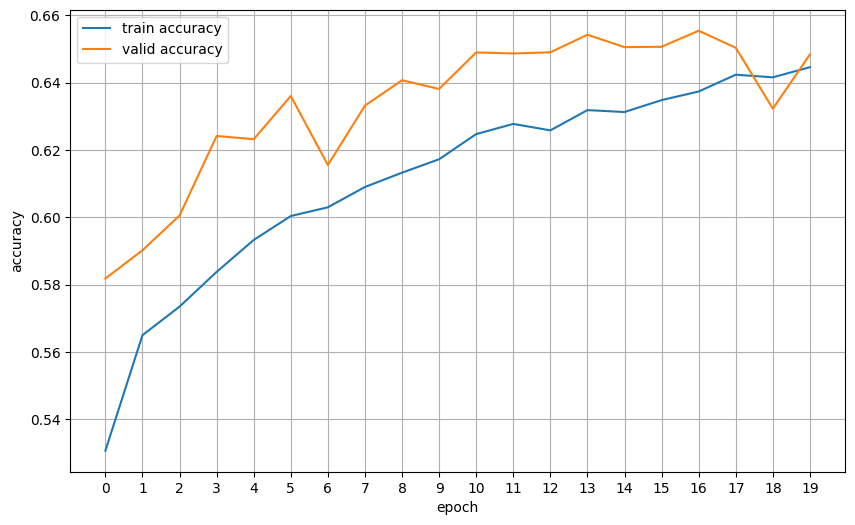

In [102]:
plot_metrics(metrics, "Bi-LSTM with 2 layers")

In [103]:
lstm_model.load_state_dict(torch.load(lstm_model_path))

<All keys matched successfully>

In [104]:
y_true, y_pred = get_labels_and_predictions(
    lstm_model, development_dataloader, encoder, device, False
)

Predicting: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 59.91it/s]


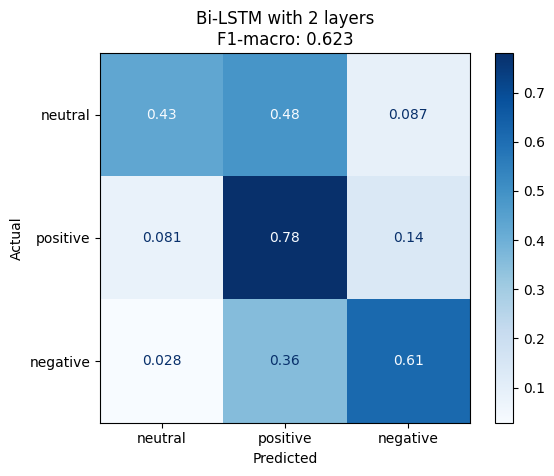

In [105]:
plot_confusion_matrix(y_true, y_pred, "Bi-LSTM with 2 layers")

## LSTM with Attention


In [106]:
vocab_size = len(vocab)
embedding_dim = 100
hidden_dim = 300
output_dim = 3
n_layers = 2
bidirectional = True
dropout_rate = 0.5

In [107]:
lstm_with_attention_model = LSTMWithAttention(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    bidirectional,
    dropout_rate,
    pad_index,
)

In [108]:
print(
    f"The LSTM with attention model has {count_parameters(lstm_with_attention_model):,} trainable parameters"
)

The LSTM with attention model has 3,132,004 trainable parameters


In [109]:
lstm_with_attention_model.embedding.weight.data = embedding_matrix

In [110]:
n_epochs = 20
lr = 5e-4
optimizer = torch.optim.Adam(lstm_with_attention_model.parameters(), lr=lr)

In [111]:
criterion = nn.CrossEntropyLoss()

In [112]:
lstm_with_attention_model = lstm_with_attention_model.to(device)
criterion = criterion.to(device)

In [113]:
lstm_with_attention_model_path = (
    models_weights_dir_path / "lstm_with_attention_model.pt"
)

In [114]:
metrics = training_loop(
    n_epochs,
    train_dataloader,
    development_dataloader,
    lstm_with_attention_model,
    criterion,
    optimizer,
    device,
    False,
    None,
    lstm_with_attention_model_path,
)

Evaluating Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 51.04it/s]


Saving model with valid loss: 0.862
epoch: 1
train_loss: 0.936, train_acc: 0.539
valid_loss: 0.862, valid_acc: 0.582


Evaluating Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 51.01it/s]


Saving model with valid loss: 0.844
epoch: 2
train_loss: 0.886, train_acc: 0.578
valid_loss: 0.844, valid_acc: 0.598


Evaluating Epoch 3: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 44.12it/s]


Saving model with valid loss: 0.815
epoch: 3
train_loss: 0.866, train_acc: 0.589
valid_loss: 0.815, valid_acc: 0.620


Evaluating Epoch 4: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 51.06it/s]


Saving model with valid loss: 0.801
epoch: 4
train_loss: 0.855, train_acc: 0.598
valid_loss: 0.801, valid_acc: 0.631


Evaluating Epoch 5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 42.47it/s]


Saving model with valid loss: 0.796
epoch: 5
train_loss: 0.847, train_acc: 0.605
valid_loss: 0.796, valid_acc: 0.632


Evaluating Epoch 6: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 46.32it/s]


epoch: 6
train_loss: 0.837, train_acc: 0.607
valid_loss: 0.802, valid_acc: 0.623


Evaluating Epoch 7: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 46.32it/s]


Saving model with valid loss: 0.787
epoch: 7
train_loss: 0.831, train_acc: 0.611
valid_loss: 0.787, valid_acc: 0.633


Evaluating Epoch 8: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 46.32it/s]


Saving model with valid loss: 0.781
epoch: 8
train_loss: 0.823, train_acc: 0.618
valid_loss: 0.781, valid_acc: 0.638


Evaluating Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 50.93it/s]


Saving model with valid loss: 0.779
epoch: 9
train_loss: 0.814, train_acc: 0.624
valid_loss: 0.779, valid_acc: 0.642


Evaluating Epoch 10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 50.92it/s]


Saving model with valid loss: 0.773
epoch: 10
train_loss: 0.810, train_acc: 0.628
valid_loss: 0.773, valid_acc: 0.646


Evaluating Epoch 11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 46.32it/s]


Saving model with valid loss: 0.770
epoch: 11
train_loss: 0.802, train_acc: 0.629
valid_loss: 0.770, valid_acc: 0.642


Evaluating Epoch 12: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 46.32it/s]


Saving model with valid loss: 0.763
epoch: 12
train_loss: 0.794, train_acc: 0.635
valid_loss: 0.763, valid_acc: 0.647


Evaluating Epoch 13: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 44.58it/s]


Saving model with valid loss: 0.756
epoch: 13
train_loss: 0.793, train_acc: 0.635
valid_loss: 0.756, valid_acc: 0.654


Evaluating Epoch 14: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 46.27it/s]


Saving model with valid loss: 0.755
epoch: 14
train_loss: 0.789, train_acc: 0.637
valid_loss: 0.755, valid_acc: 0.656


Evaluating Epoch 15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 42.48it/s]


epoch: 15
train_loss: 0.779, train_acc: 0.643
valid_loss: 0.764, valid_acc: 0.657


Evaluating Epoch 16: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 46.57it/s]


epoch: 16
train_loss: 0.775, train_acc: 0.646
valid_loss: 0.761, valid_acc: 0.650


Evaluating Epoch 17: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 42.48it/s]


Saving model with valid loss: 0.751
epoch: 17
train_loss: 0.768, train_acc: 0.648
valid_loss: 0.751, valid_acc: 0.660


Evaluating Epoch 18: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 42.45it/s]


epoch: 18
train_loss: 0.766, train_acc: 0.651
valid_loss: 0.773, valid_acc: 0.640


Evaluating Epoch 19: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 45.45it/s]


epoch: 19
train_loss: 0.758, train_acc: 0.654
valid_loss: 0.755, valid_acc: 0.656


Evaluating Epoch 20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 46.31it/s]


epoch: 20
train_loss: 0.755, train_acc: 0.654
valid_loss: 0.752, valid_acc: 0.663


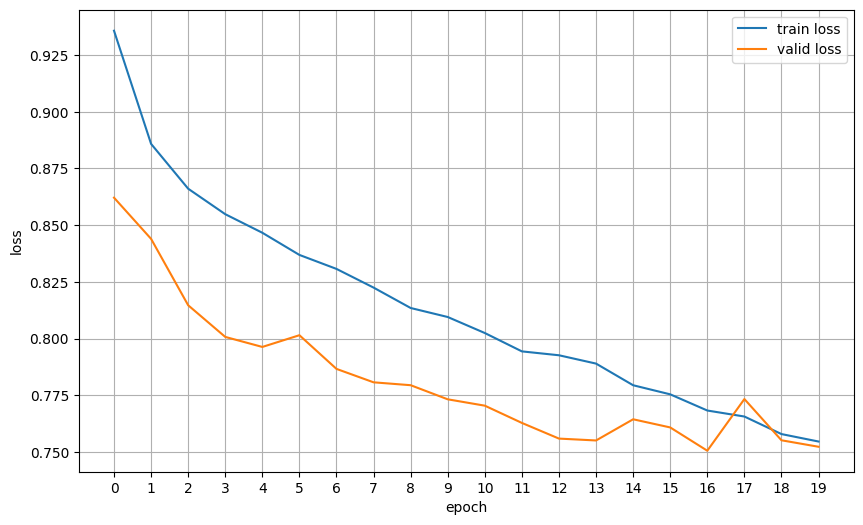

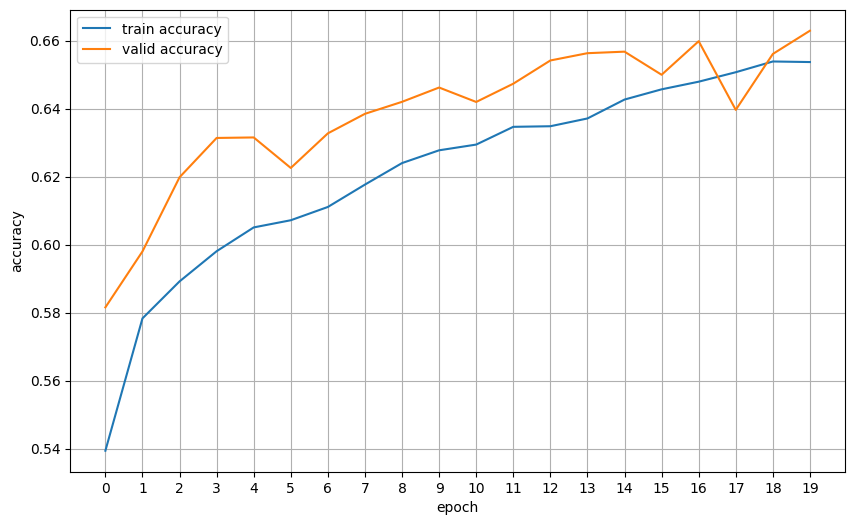

In [115]:
plot_metrics(metrics, "Bi-LSTM with attention")

In [116]:
lstm_with_attention_model.load_state_dict(torch.load(lstm_with_attention_model_path))

<All keys matched successfully>

In [117]:
y_true, y_pred = get_labels_and_predictions(
    lstm_with_attention_model, development_dataloader, encoder, device, False
)

Predicting: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 59.88it/s]


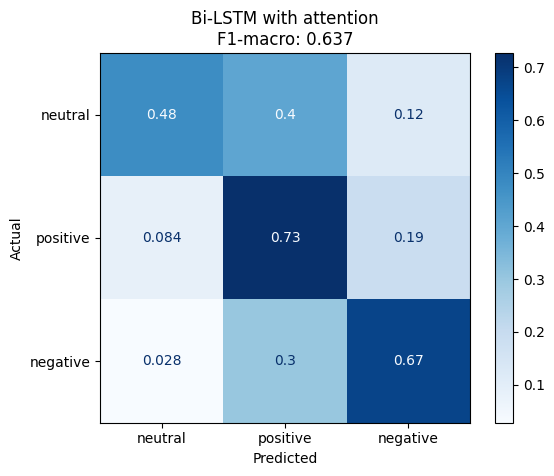

In [118]:
plot_confusion_matrix(y_true, y_pred, "Bi-LSTM with attention")

## BERT


In [119]:
transformer_name = "bert-base-uncased"
bert_tokenizer = transformers.AutoTokenizer.from_pretrained(transformer_name)
bert_transformer = transformers.AutoModel.from_pretrained(transformer_name)

In [120]:
print(bert_transformer.config.hidden_size)

768


In [121]:
batch_size = 8
n_epochs = 3
lr = 1e-5

The BERT sentiment model has 109,484,547 trainable parameters


Evaluating Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:09<00:00, 26.05it/s]


Saving model with valid loss: 0.568
epoch: 1
train_loss: 0.664, train_acc: 0.695
valid_loss: 0.568, valid_acc: 0.742


Evaluating Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:09<00:00, 26.10it/s]


epoch: 2
train_loss: 0.498, train_acc: 0.784
valid_loss: 0.586, valid_acc: 0.746


Evaluating Epoch 3: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:09<00:00, 26.06it/s]


epoch: 3
train_loss: 0.333, train_acc: 0.862
valid_loss: 0.725, valid_acc: 0.726


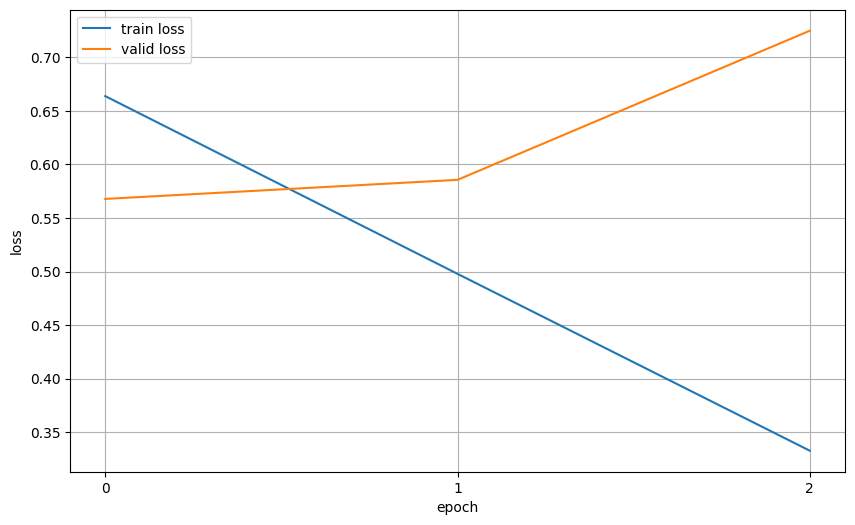

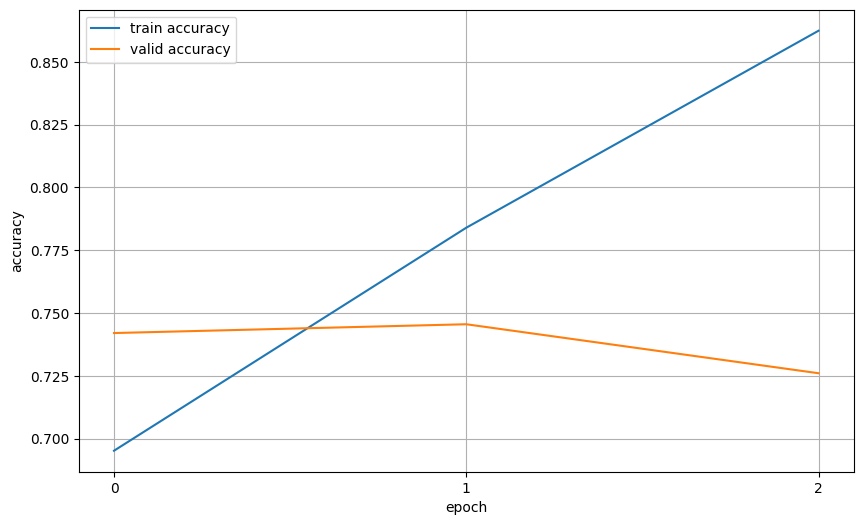

Predicting: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:09<00:00, 27.17it/s]


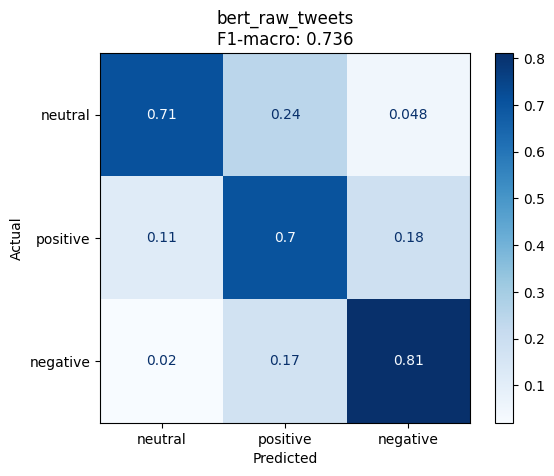

The BERT sentiment model has 109,484,547 trainable parameters


Evaluating Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:09<00:00, 26.13it/s]


Saving model with valid loss: 0.675
epoch: 1
train_loss: 0.673, train_acc: 0.700
valid_loss: 0.675, valid_acc: 0.692


Evaluating Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:09<00:00, 26.06it/s]


epoch: 2
train_loss: 0.536, train_acc: 0.770
valid_loss: 0.713, valid_acc: 0.692


Evaluating Epoch 3: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:09<00:00, 25.94it/s]


epoch: 3
train_loss: 0.377, train_acc: 0.845
valid_loss: 0.838, valid_acc: 0.680


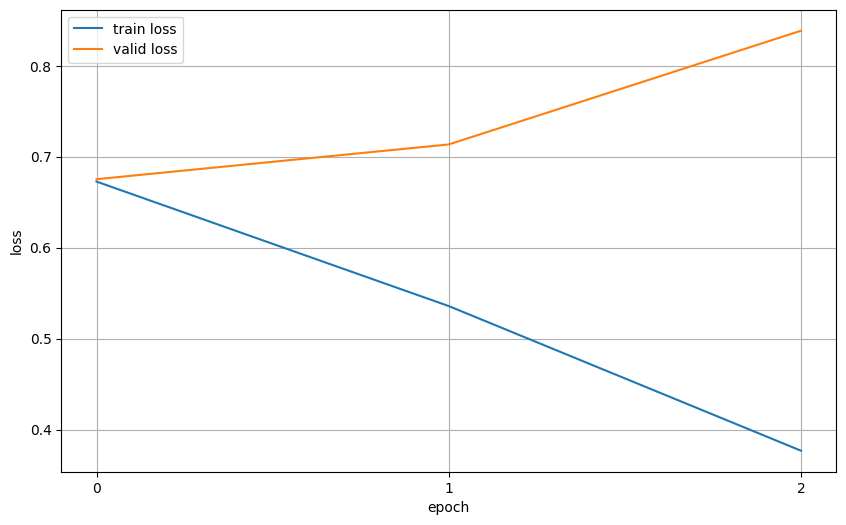

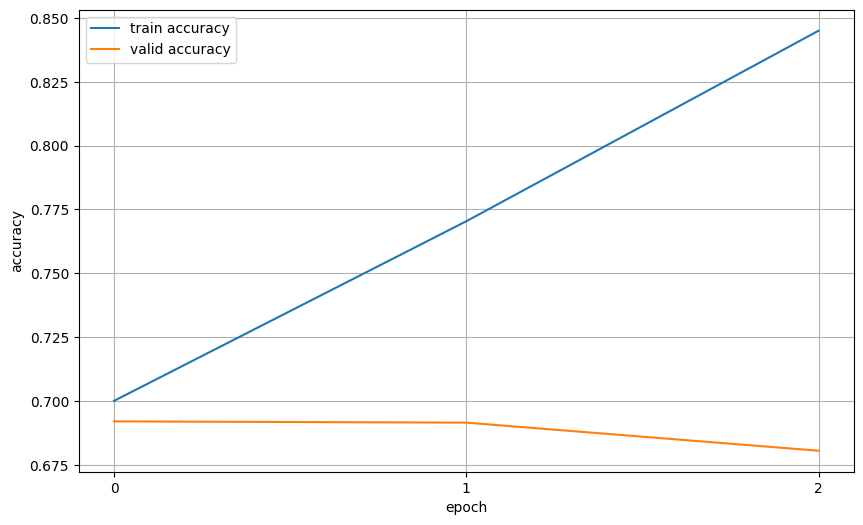

Predicting: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:09<00:00, 26.95it/s]


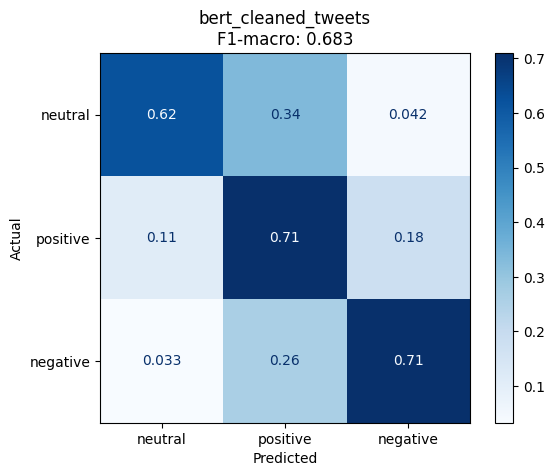

In [122]:
for experiment_name, feature_column in [
    ("bert_raw_tweets", "tweet_text"),
    ("bert_cleaned_tweets", "tweet_text_cleaned"),
]:
    # create BERT-based dataset
    bert_train_dataset = BERTTweetsDataset(
        tweet_ids=training_data["tweet_id"],
        tweets=training_data[feature_column],
        labels=training_data["tweet_sentiment"],
        tokenizer=bert_tokenizer,
        label_encoder=encoder,
    )

    bert_development_dataset = BERTTweetsDataset(
        tweet_ids=development_data["tweet_id"],
        tweets=development_data[feature_column],
        labels=development_data["tweet_sentiment"],
        tokenizer=bert_tokenizer,
        label_encoder=encoder,
    )

    # create dataloaders
    bert_train_dataloader = DataLoader(
        bert_train_dataset, batch_size=batch_size, shuffle=True
    )

    bert_development_dataloader = DataLoader(
        bert_development_dataset, batch_size=batch_size, shuffle=False
    )

    bert_model = BERTClassifier(
        transformer=bert_transformer, output_dim=len(encoder.classes_), freeze=False
    )

    optimizer = torch.optim.Adam(bert_model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    bert_model = bert_model.to(device)
    criterion = criterion.to(device)

    print(
        f"The BERT sentiment model has {count_parameters(bert_model):,} trainable parameters"
    )

    bert_model_path = models_weights_dir_path / f"{experiment_name}.pt"

    metrics = training_loop(
        n_epochs,
        bert_train_dataloader,
        bert_development_dataloader,
        bert_model,
        criterion,
        optimizer,
        device,
        True,
        None,
        bert_model_path,
    )

    plot_metrics(metrics, experiment_name)

    bert_model.load_state_dict(torch.load(bert_model_path))

    y_true, y_pred = get_labels_and_predictions(
        bert_model,
        bert_development_dataloader,
        encoder,
        device,
        True,
    )

    plot_confusion_matrix(y_true, y_pred, experiment_name)

# Calculating predictions on test1, test2, and test3 datasets


In this section, we will load saved models in the `models_weights` folder, and calculate predictions and `f1` score for the three testing datasets.


## Naive Bayes, Logistic Regression, and SVM


In [123]:
naive_bayes_pipeline = joblib.load(models_weights_dir_path / "naive_bayes_model.joblib")
logistic_regression_pipeline = joblib.load(
    models_weights_dir_path / "logistic_regression_model.joblib"
)
svm_pipeline = joblib.load(models_weights_dir_path / "svm_model.joblib")

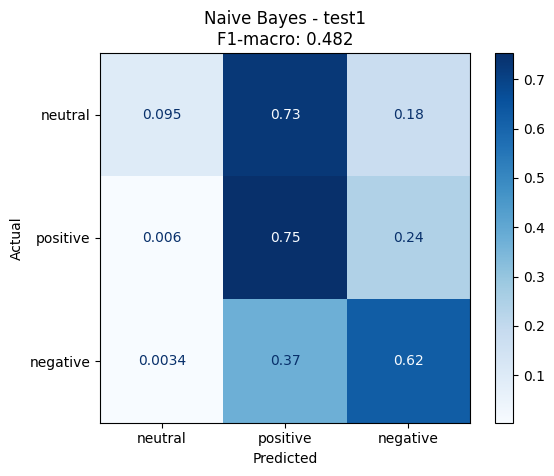

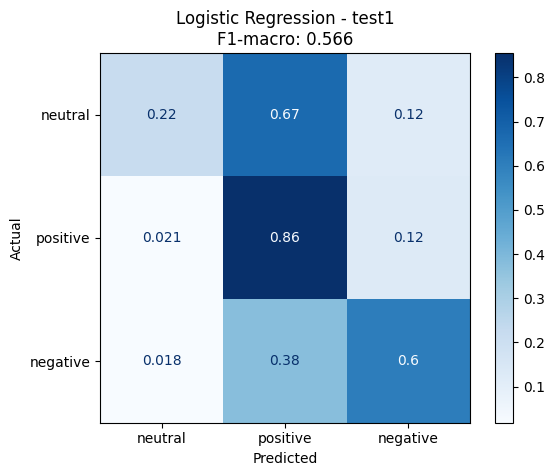

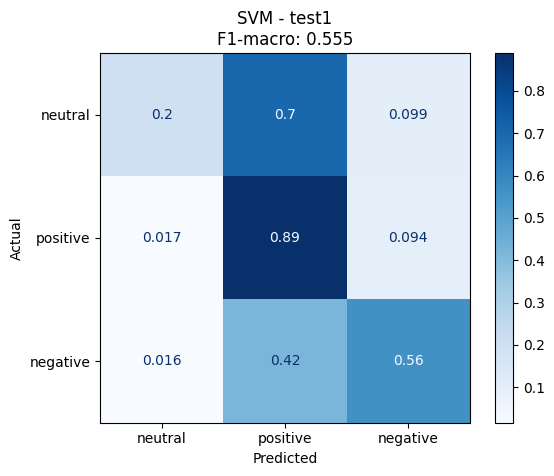

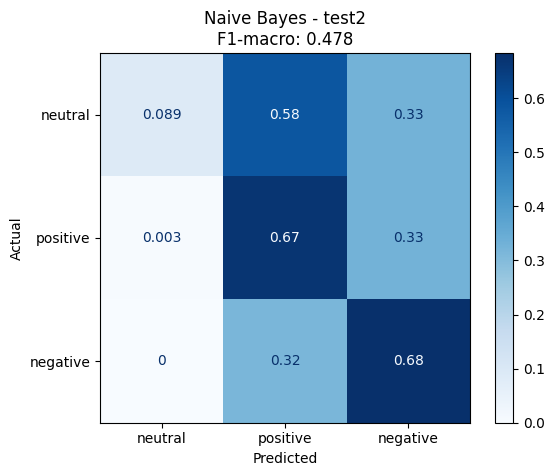

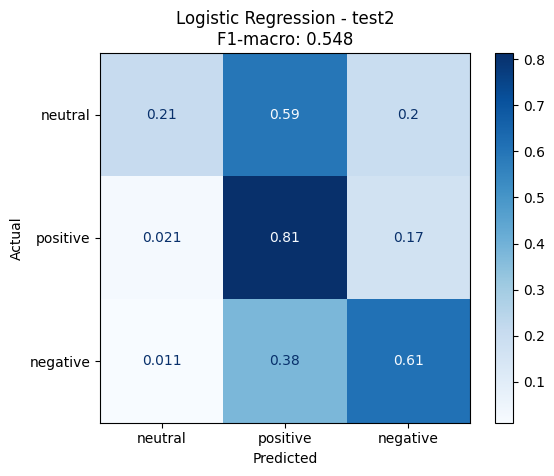

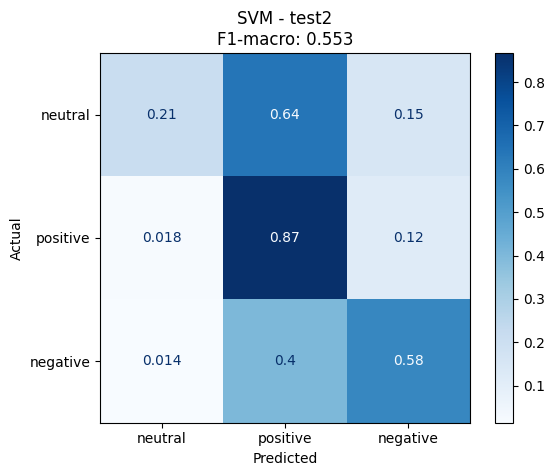

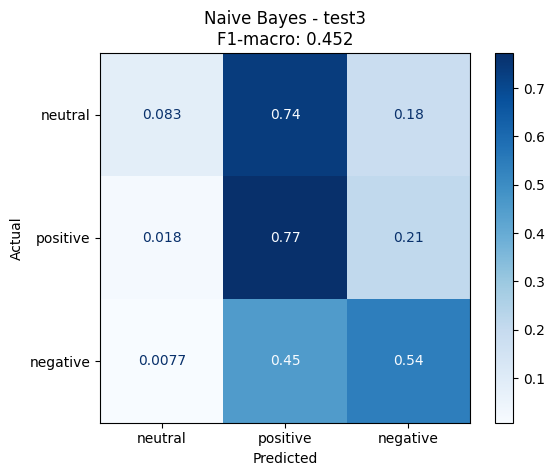

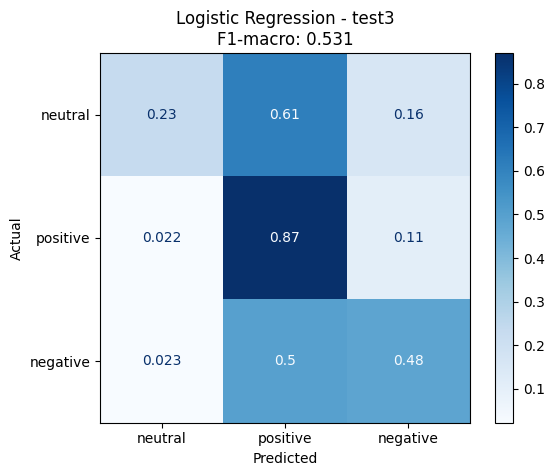

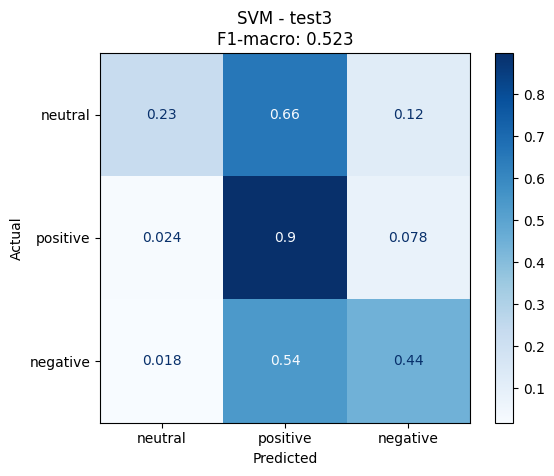

In [124]:
for test_data, test_data_name in [
    (test1_data, "test1"),
    (test2_data, "test2"),
    (test3_data, "test3"),
]:
    y_true = test_data["tweet_sentiment"]

    y_pred_nb = naive_bayes_pipeline.predict(test_data["tweet_text_cleaned"])
    y_pred_lr = logistic_regression_pipeline.predict(test_data["tweet_text_cleaned"])
    y_pred_svm = svm_pipeline.predict(test_data["tweet_text_cleaned"])

    plot_confusion_matrix(y_true, y_pred_nb, f"Naive Bayes - {test_data_name}")

    plot_confusion_matrix(
        y_true,
        y_pred_lr,
        f"Logistic Regression - {test_data_name}",
    )

    plot_confusion_matrix(y_true, y_pred_svm, f"SVM - {test_data_name}")

## LSTM, LSTM with attention


In [125]:
lstm_model.load_state_dict(torch.load(models_weights_dir_path / "lstm_model.pt"))

<All keys matched successfully>

In [126]:
lstm_with_attention_model.load_state_dict(
    torch.load(models_weights_dir_path / "lstm_with_attention_model.pt")
)

<All keys matched successfully>

Predicting: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 35.01it/s]


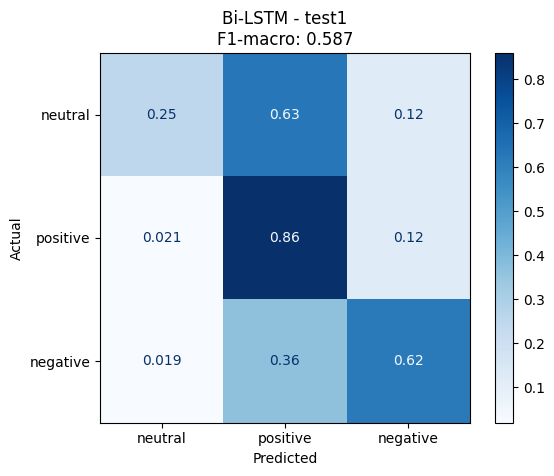

Predicting: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 55.70it/s]


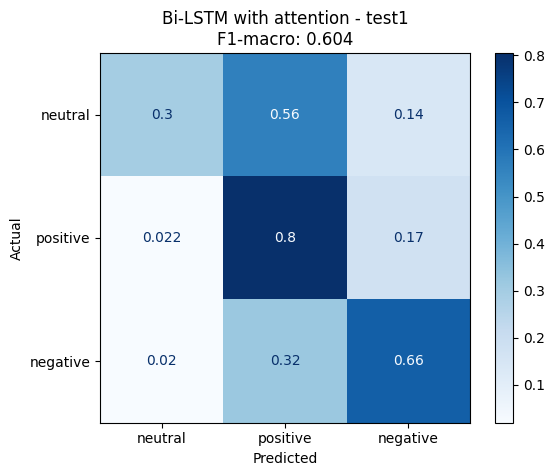

Predicting: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 50.92it/s]


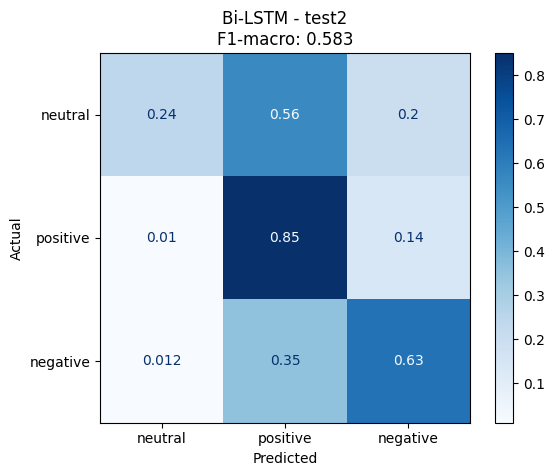

Predicting: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 49.76it/s]


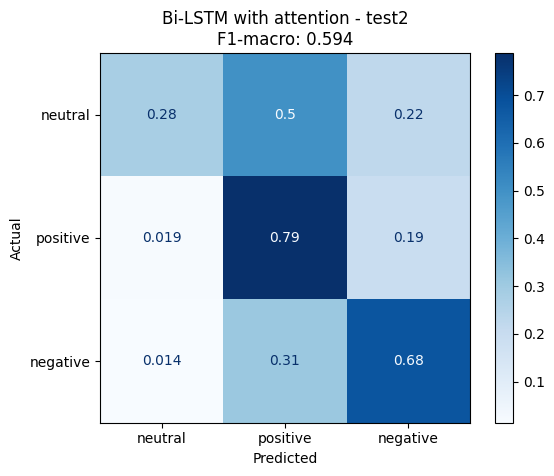

Predicting: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 55.94it/s]


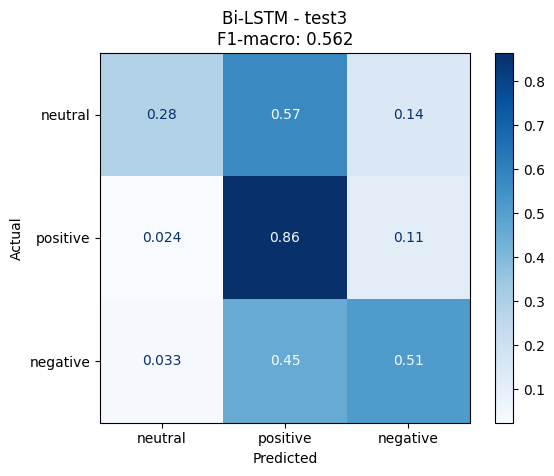

Predicting: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 57.89it/s]


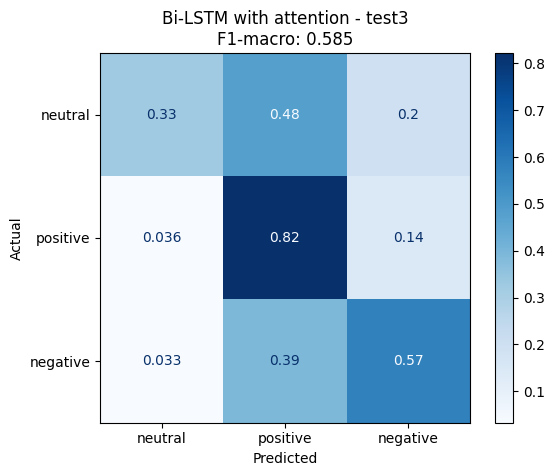

In [127]:
for test_data, test_data_name in [
    (test1_data, "test1"),
    (test2_data, "test2"),
    (test3_data, "test3"),
]:
    test_dataset = TweetsDataset(
        tweet_ids=test_data["tweet_id"],
        tweets=test_data["tweet_text_cleaned"],
        labels=test_data["tweet_sentiment"],
        vocab=vocab,
        label_encoder=encoder,
    )

    batch_size = 256

    test_data_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch
    )

    y_true, y_pred = get_labels_and_predictions(
        lstm_model, test_data_loader, encoder, device, False
    )

    plot_confusion_matrix(y_true, y_pred, f"Bi-LSTM - {test_data_name}")

    y_true, y_pred = get_labels_and_predictions(
        lstm_with_attention_model, test_data_loader, encoder, device, False
    )

    plot_confusion_matrix(y_true, y_pred, f"Bi-LSTM with attention - {test_data_name}")

## BERT


In [128]:
bert_transformer = transformers.AutoModel.from_pretrained(transformer_name)

bert_raw_tweets = BERTClassifier(
    transformer=bert_transformer, output_dim=len(encoder.classes_), freeze=False
)

bert_raw_tweets.load_state_dict(
    torch.load(models_weights_dir_path / "bert_raw_tweets.pt")
)

bert_raw_tweets = bert_raw_tweets.to(device)

In [129]:
bert_transformer = transformers.AutoModel.from_pretrained(transformer_name)

bert_cleaned_tweets = BERTClassifier(
    transformer=bert_transformer, output_dim=len(encoder.classes_), freeze=False
)

bert_cleaned_tweets.load_state_dict(
    torch.load(models_weights_dir_path / "bert_cleaned_tweets.pt")
)

bert_cleaned_tweets = bert_cleaned_tweets.to(device)

Predicting: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 442/442 [00:16<00:00, 27.58it/s]


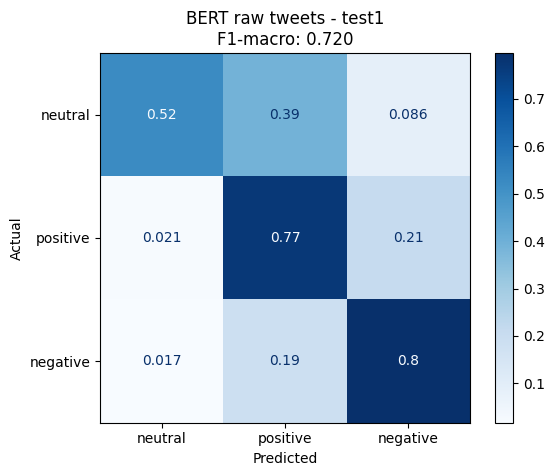

Predicting: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 442/442 [00:16<00:00, 27.49it/s]


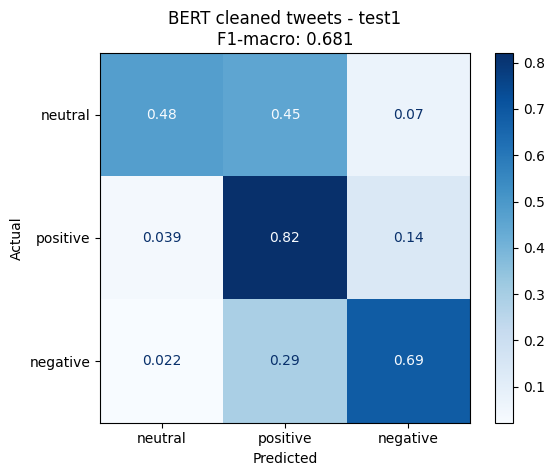

Predicting: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 232/232 [00:08<00:00, 27.37it/s]


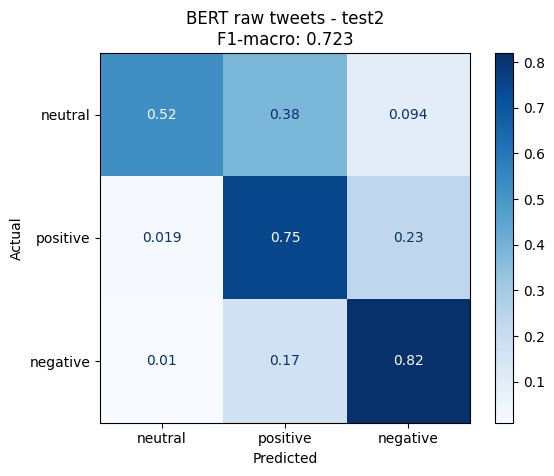

Predicting: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 232/232 [00:08<00:00, 27.42it/s]


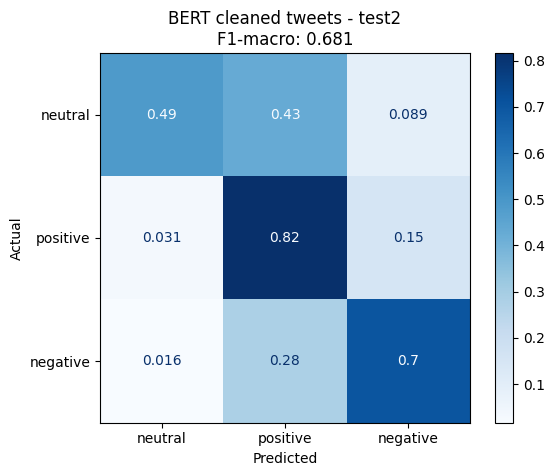

Predicting: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 298/298 [00:10<00:00, 27.27it/s]


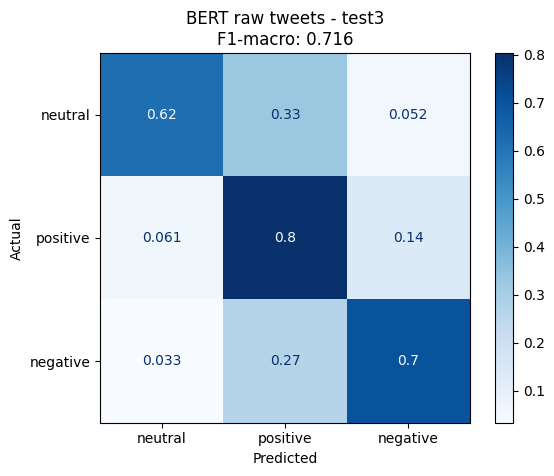

Predicting: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 298/298 [00:10<00:00, 27.31it/s]


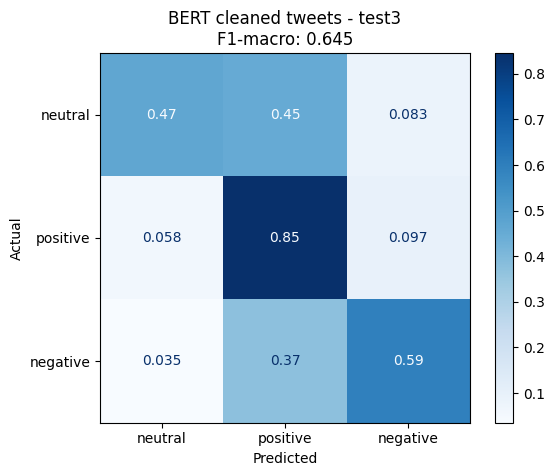

In [130]:
for test_data, test_data_name in [
    (test1_data, "test1"),
    (test2_data, "test2"),
    (test3_data, "test3"),
]:

    bert_dataset = BERTTweetsDataset(
        tweet_ids=test_data["tweet_id"],
        tweets=test_data["tweet_text"],
        labels=test_data["tweet_sentiment"],
        tokenizer=bert_tokenizer,
        label_encoder=encoder,
    )

    batch_size = 8

    bert_data_loader = DataLoader(bert_dataset, batch_size=batch_size, shuffle=False)

    y_true, y_pred = get_labels_and_predictions(
        bert_raw_tweets, bert_data_loader, encoder, device, True
    )

    plot_confusion_matrix(y_true, y_pred, f"BERT raw tweets - {test_data_name}")

    bert_dataset = BERTTweetsDataset(
        tweet_ids=test_data["tweet_id"],
        tweets=test_data["tweet_text_cleaned"],
        labels=test_data["tweet_sentiment"],
        tokenizer=bert_tokenizer,
        label_encoder=encoder,
    )

    bert_data_loader = DataLoader(bert_dataset, batch_size=batch_size, shuffle=False)

    y_true, y_pred = get_labels_and_predictions(
        bert_cleaned_tweets, bert_data_loader, encoder, device, True
    )

    plot_confusion_matrix(y_true, y_pred, f"BERT cleaned tweets - {test_data_name}")